## RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

### Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 


Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    - hit  — взять ещё одну карту;
    - stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
-в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).



In [4]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from IPython.display import clear_output

from collections import defaultdict

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

### 1.1
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [5]:
env = gym.make('Blackjack-v1', natural=True)

In [6]:
HIT = 1
STAND = 0

In [7]:
env.reset()

(8, 10, False)

In [8]:
simple_strategy = lambda env, state: HIT if state[0] < 19 else STAND
print_stats = lambda stats: print(f'Среднее значение выигрыша: {stats[0]}, СКВО: {stats[1]}') 

In [9]:
def play(env, strategy_func, n=100_000):
    rewards = [0] * n
    for i in range(n):
        state = env.reset()
        is_finished = False
        reward = 0
        while not is_finished:
            action = strategy_func(env, state)
            state, reward, is_finished, _ = env.step(action)
        rewards[i] = reward
    return rewards

def compute_stats(rewards, conf=0.95):
    mean = np.mean(rewards)
    std = np.std(rewards)
    return mean, std

def plot_strategy_mean(rewards, title=None):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(rewards)), rewards)
    plt.xlabel('Количество эпох')
    plt.ylabel('Средний выигрыш')
    if title is not None:
        plt.title(title)
    plt.ylim((-0.5, 0.01))
    plt.show()

In [10]:
%%time
simple_strategy_reward = play(env, simple_strategy, n=1 * 10 ** 5)

CPU times: user 10.2 s, sys: 30.9 ms, total: 10.3 s
Wall time: 10.1 s


In [11]:
stats = compute_stats(simple_strategy_reward)
print_stats(stats)

Среднее значение выигрыша: -0.19608, СКВО: 0.9431715822691014


В среднем наш проигрыш составляет 0.2 поставленной ставки

### 1.2
Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.


In [38]:
def eps_greedy_strategy(env, state, epsilon, Q):
    if np.random.random() > epsilon:
        return Q[state].argmax()
    else:
        return np.random.randint(0, env.action_space.n - 1)

def play_episode(env, strategy_func):
    states, actions, rewards = list(), list(), list()
    is_finished = False
    state = env.reset()
    
    while not is_finished:
        states.append(state)
        action = strategy_func(env, state)
        actions.append(action)
        state, reward, is_finished, _ = env.step(action)
        rewards.append(reward)
        
    env.close()
    return states, actions, rewards

def monte_carlo(env, n_episodes=100000, evaluate_every=10_000, alpha=1., gamma=0.3, decay=0.9999, epsilon=1., verbose=False):
    
    n = env.action_space.n
    gamma_rewards = defaultdict(list)
    Qs = list()
    default_epsilon = epsilon
    
    if not isinstance(gamma, list):
        gamma = [gamma]
    
    for g in gamma:
        epsilon = default_epsilon
        if verbose:
            print(f'Fitting for gamma={g}')
            
        Q = defaultdict(lambda: np.random.random(n))
#         N = defaultdict(int)
        
    
        for i in range(n_episodes):
            strategy_func = lambda env, state: eps_greedy_strategy(env, state, epsilon, Q)

            if (i + 1) % evaluate_every == 0 or i == 0:
                best_strategy_func = lambda env, state: Q[state].argmax()
                new_strategy_rewards = play(env, best_strategy_func, n=100_000)

                gamma_rewards[g].append(np.mean(new_strategy_rewards))
                if verbose:
                    print(f"Fit step: {i + 1} from {n_episodes}, test strategy reward: {gamma_rewards[g][-1]}, epsilon for training: {epsilon:.3f}")

            states, actions, rewards = play_episode(env, strategy_func)
            G = 0
            for step in range(len(states) - 1, -1, -1):
                state = states[step]
                action = actions[step]
                reward = rewards[step]
                G = g * G + reward
#                 if (state, action) not in zip(states[:step], actions[:step]):
#                     N[(state, action)] += 1
                Q[state][action] += alpha * (G - Q[state][action]) #/ N[(state, action)] # using / N instead of alpha
            epsilon = max(epsilon * decay, 0.1)
            
        Qs.append(Q)
    
    
    return gamma_rewards, Qs

In [39]:
env = gym.make('Blackjack-v1', natural=True)
gamma = [i * 0.1 for i in range(2, 10, 3)]
evaluate_every = 20_000
n_episodes = 2 * 10 ** 5
epsilon = 1.
alpha = 0.05

In [40]:
%%time
rewards, Qs = monte_carlo(env, n_episodes=n_episodes, epsilon=epsilon, evaluate_every=evaluate_every, alpha=alpha, gamma=gamma, verbose=True)

Fitting for gamma=0.2
Fit step: 1 from 200000, test strategy reward: -0.41856, epsilon for training: 1.000
Fit step: 20000 from 200000, test strategy reward: -0.06158, epsilon for training: 0.135
Fit step: 40000 from 200000, test strategy reward: -0.06655, epsilon for training: 0.100
Fit step: 60000 from 200000, test strategy reward: -0.06018, epsilon for training: 0.100
Fit step: 80000 from 200000, test strategy reward: -0.06574, epsilon for training: 0.100
Fit step: 100000 from 200000, test strategy reward: -0.06077, epsilon for training: 0.100
Fit step: 120000 from 200000, test strategy reward: -0.05061, epsilon for training: 0.100
Fit step: 140000 from 200000, test strategy reward: -0.05202, epsilon for training: 0.100
Fit step: 160000 from 200000, test strategy reward: -0.05492, epsilon for training: 0.100
Fit step: 180000 from 200000, test strategy reward: -0.05824, epsilon for training: 0.100
Fit step: 200000 from 200000, test strategy reward: -0.05177, epsilon for training: 0.1

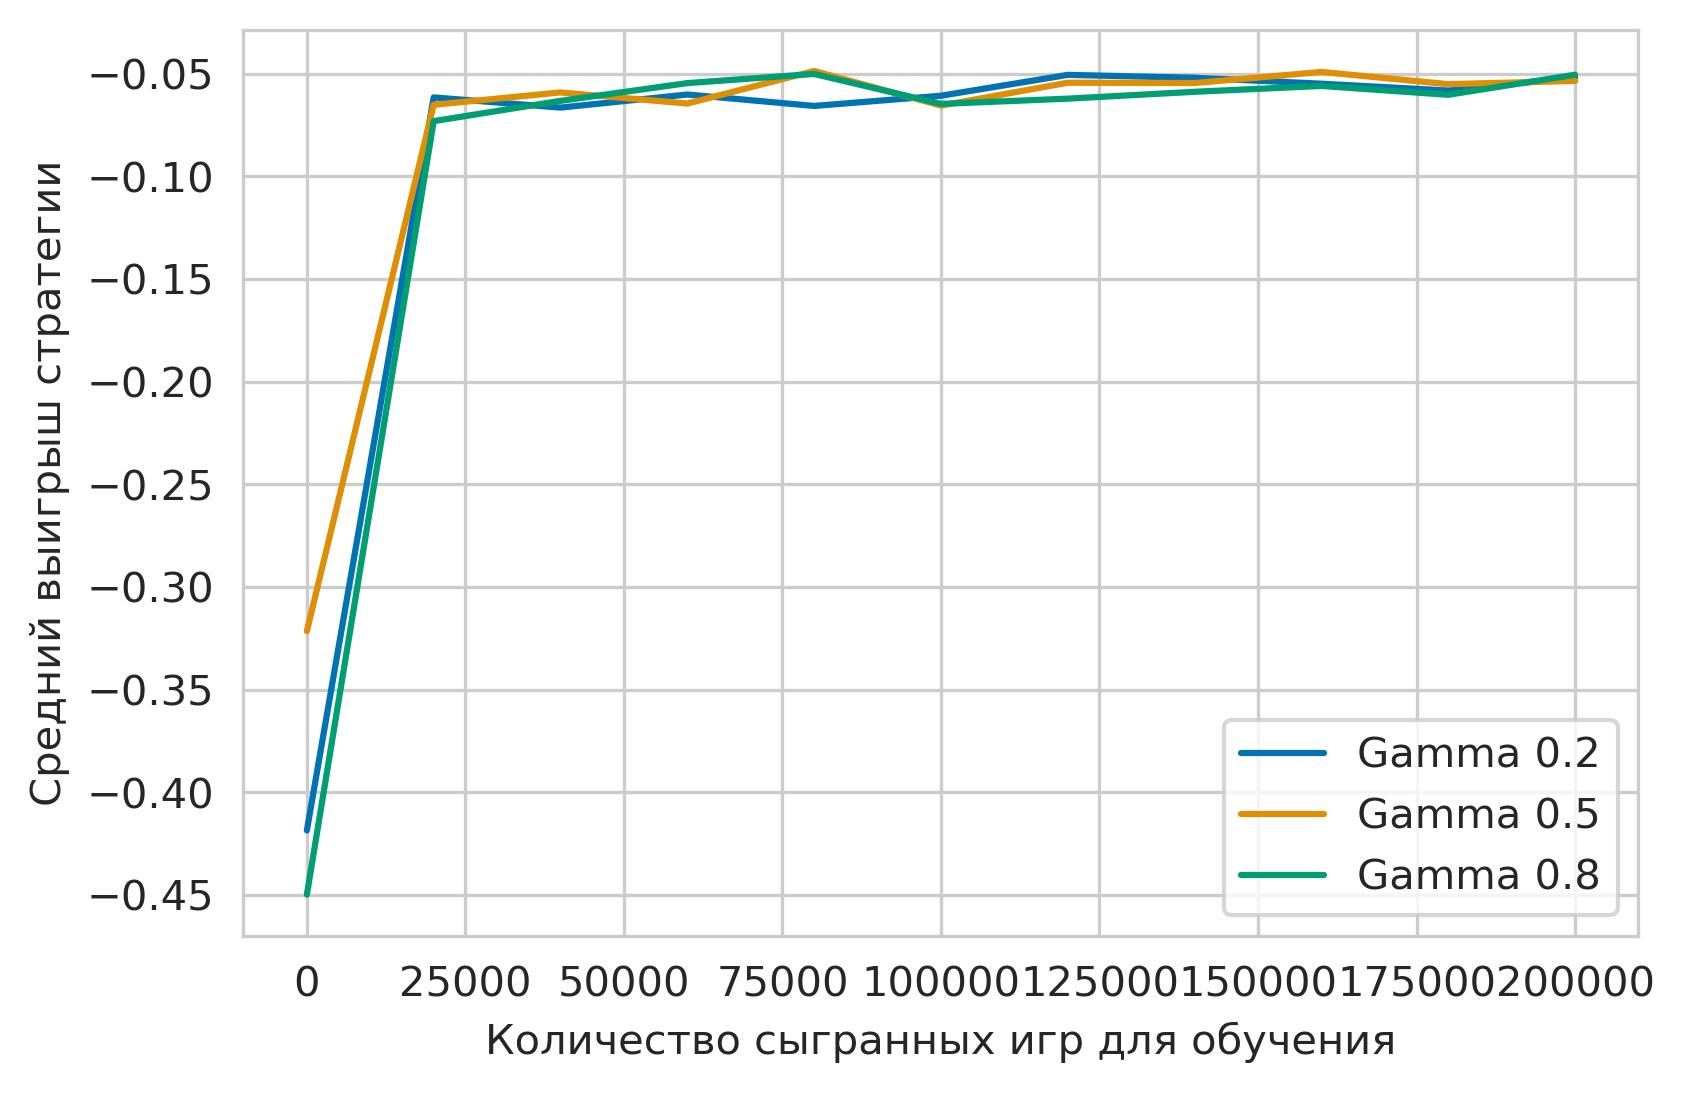

In [42]:
for g in rewards:
    vals = rewards[g]
    plt.plot(range(0, n_episodes + 1, evaluate_every), vals, label=f'Gamma {g}')
    
plt.legend()
plt.xlabel('Количество сыгранных игр для обучения')
plt.ylabel('Средний выигрыш стратегии')
plt.show()

Как видим удалось увеличить средний выигрыш, который все еще отрицательный, в результате перебора гипер параметров удалось получить стратегию при которой наш выигрыш составляет примерно -0.05 поставленной ставки.

### Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.


1. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

2. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [71]:
from typing import Optional

import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class DoubleBlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab
        
    def draw_card(self, np_random):
        return int(np_random.choice(deck))


    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:  # double reward
            self.player.append(self.draw_card(self.np_random))
            done = True
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self, seed: Optional[int] = None):
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

In [85]:
env_2 = DoubleBlackjackEnv(natural=True)
gamma = [i * 0.1 for i in range(2, 10, 2)]
evaluate_every = 20_000
n_episodes = 2 * 10 ** 5
epsilon = 1.
alpha = 0.05

In [ ]:
%%time
rewards, Qs = monte_carlo(env_2, n_episodes=n_episodes, epsilon=epsilon, evaluate_every=evaluate_every, alpha=alpha, gamma=gamma, verbose=True)

Fitting for gamma=0.2
Fit step: 1 from 200000, test strategy reward: -0.530155, epsilon for training: 1.000


In [ ]:
for g in rewards:
    vals = rewards[g]
    plt.plot(range(0, n_episodes + 1, evaluate_every), vals, label=f'Gamma {g}')
    
plt.legend()
plt.xlabel('Количество сыгранных игр для обучения')
plt.ylabel('Средний выигрыш стратегии')
plt.show()

### Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.


1. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
2. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [ ]:
class BlackjackWithCounter(DoubleBlackjackEnv):
    card_points = {
            1: -1,
            2: 0.5,
            3: 1,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }
    
    def __init__(self, natural=False):
        super().__init__(natural)
        self.deck_counter = 0.0
        self.deck = deck.copy()

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Box(-22.0, 22.0, dtype=np.float32)))
        
        self.reset()

    def draw_card(self, np_random):
        rand_idx = np.random.choice(range(len(self.deck)))
        card = self.deck.pop(rand_ind)
        self.deck_counter += self.card_points[card]
        return int(card)

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.card_counter)

    def reset(self):
        if len(self.deck) < 15:
            self.deck_counter = 0.0
            self.deck = deck.copy()
        
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

In [81]:
env_3 = DoubleBlackjackEnv(natural=True)
gamma = [i * 0.1 for i in range(2, 10, 2)]
evaluate_every = 20_000
n_episodes = 2 * 10 ** 5
epsilon = 1.
alpha = 0.05

In [82]:
%%time
rewards, Qs = monte_carlo(env_3, n_episodes=n_episodes, epsilon=epsilon, evaluate_every=evaluate_every, decay=0.99995, alpha=alpha, gamma=gamma, verbose=True)

Fitting for gamma=0.2
Fit step: 1 from 200000, test strategy reward: -0.57908, epsilon for training: 1.000
Fit step: 20000 from 200000, test strategy reward: -0.072785, epsilon for training: 0.368
Fit step: 40000 from 200000, test strategy reward: -0.049075, epsilon for training: 0.135
Fit step: 60000 from 200000, test strategy reward: -0.045415, epsilon for training: 0.100
Fit step: 80000 from 200000, test strategy reward: -0.031865, epsilon for training: 0.100
Fit step: 100000 from 200000, test strategy reward: -0.036415, epsilon for training: 0.100
Fit step: 120000 from 200000, test strategy reward: -0.030235, epsilon for training: 0.100
Fit step: 140000 from 200000, test strategy reward: -0.033635, epsilon for training: 0.100
Fit step: 160000 from 200000, test strategy reward: -0.04129, epsilon for training: 0.100
Fit step: 180000 from 200000, test strategy reward: -0.02757, epsilon for training: 0.100
Fit step: 200000 from 200000, test strategy reward: -0.038785, epsilon for train

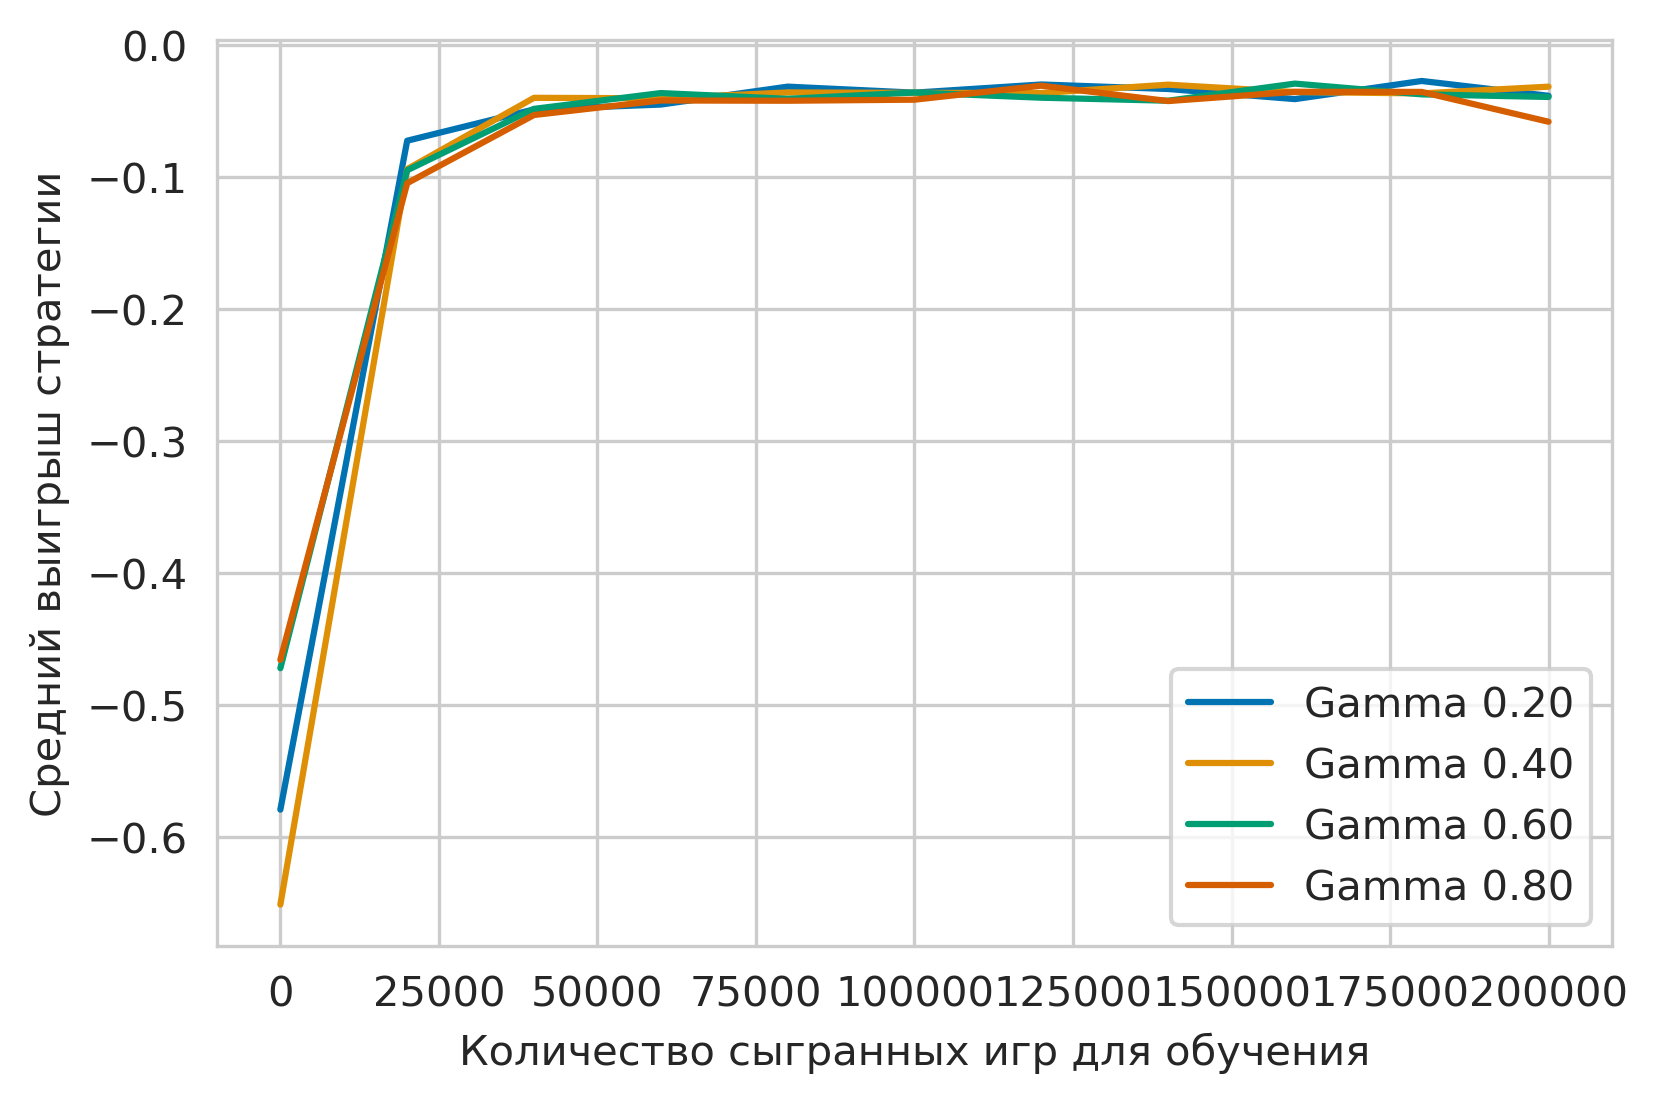

In [84]:
for g in rewards:
    vals = rewards[g]
    plt.plot(range(0, n_episodes + 1, evaluate_every), vals, label=f'Gamma {g:.2f}')
    
plt.legend()
plt.xlabel('Количество сыгранных игр для обучения')
plt.ylabel('Средний выигрыш стратегии')
plt.show()

Обыграть казино так и не удалось, однако подсчет карт позволил слегка уменьшить наш средний проигрыш для большинства обученных стратегий.